In [1]:
import numpy as np
import h5py
import keras
from collections import OrderedDict

Using TensorFlow backend.


In [2]:
!echo $CUDA_VISIBLE_DEVICES

4


In [22]:
celltype_to_corefiles = {
    'HepG2': {
        'modeljson': '/users/eprakash/projects/benchmarking/newdata/HepG2/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_ppZZI_modelJson.json',
        'modelweights': '/users/eprakash/projects/benchmarking/newdata/HepG2/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_ppZZI_modelWeights.h5',
        'valid_positive_set': '/users/eprakash/projects/benchmarking/newdata/HepG2/HepG2.summits.400bp.implanted.valid.bed.gz',
        'valid_negative_set': '/users/eprakash/projects/benchmarking/newdata/HepG2/no_HepG2_universal_dnase.matched.valid.bed.gz'
    },
    'A549': {
        'modeljson': '/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_ugaHs_modelJson.json',
        'modelweights': '/users/eprakash/projects/benchmarking/newdata/A549/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_ugaHs_modelWeights.h5',
        'valid_positive_set': '/users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.implanted.train.bed.gz',
        'valid_negative_set': '/users/eprakash/projects/benchmarking/newdata/A549/no_A549_universal_dnase.matched.valid.bed.gz'
    },
    'H1ESC': {
        'modeljson': '/users/eprakash/projects/benchmarking/newdata/H1ESC/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_rjU3H_modelJson.json',
        'modelweights': '/users/eprakash/projects/benchmarking/newdata/H1ESC/models/deepseabeluga/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_rjU3H_modelWeights.h5',
        'valid_positive_set': '/users/eprakash/projects/benchmarking/newdata/H1ESC/H1ESC.summits.400bp.implanted.valid.bed.gz',
        'valid_negative_set': '/users/eprakash/projects/benchmarking/newdata/H1ESC/no_H1ESC_universal_dnase.matched.valid.bed.gz'
    },
    'K562': {
        'modeljson': '/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/oldmodels/record_4_model_4W8mu_modelJson.json',
        'modelweights': '/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/oldmodels/record_4_model_4W8mu_modelWeights.h5',
        'valid_positive_set': '/users/eprakash/projects/benchmarking/newdata/deepsea_K562/K562.pos.summits.valid.implanted.bed.gz',
        'valid_negative_set': '/users/eprakash/projects/benchmarking/newdata/deepsea_K562/K562.neg.summits.valid.implanted.bed.gz'
    }
}

In [29]:
import keras
import gzip


def load_keras_model(modeljson, modelweights):
    model = keras.models.model_from_json(open(modeljson).read())
    model.load_weights(modelweights)
    return model

    
def onehot_encode(seqs):
    ltr = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], 'N': [0,0,0,0]}
    return np.array([[ltr[x] for x in seq.upper()] for seq in seqs])


def load_seqs_and_onehot(sequences_file):
    seqids = []
    seqs = []
    for line in gzip.open(sequences_file):
        seqid, seq = line.decode("utf-8").rstrip().split("\t")
        seqids.append(seqid)
        seqs.append(seq)
    onehotseqs = onehot_encode(seqs)
    return seqids, seqs, onehotseqs



In [68]:
import deeplift
from deeplift.conversion import kerasapi_conversion as kc
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import sys

celltypes = ['H1ESC']

num_to_make_preds_on = 5000

for celltype in celltypes:
    print("On cell type",celltype)
    sys.stdout.flush()
    corefiles = celltype_to_corefiles[celltype]
    keras.backend.clear_session()
    
    deeplift_genomicsdefault_model =\
        kc.convert_model_from_saved_files(
            json_file=corefiles['modeljson'],
            h5_file=corefiles['modelweights'],
            nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.DeepLIFT_GenomicsDefault) 
    deeplift_rescale_model =\
        kc.convert_model_from_saved_files(
            json_file=corefiles['modeljson'],
            h5_file=corefiles['modelweights'],
            nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.Rescale) 
    pred_func = deeplift.util.compile_func(
    inputs=[deeplift_genomicsdefault_model.get_layers()[0].get_activation_vars()],
    outputs=deeplift_genomicsdefault_model.get_layers()[-2].get_activation_vars()[:,0])
    
    (pos_seqids, pos_seqs, pos_onehotseqs) = (
        load_seqs_and_onehot(sequences_file=corefiles['valid_positive_set']))
    (neg_seqids, neg_seqs, neg_onehotseqs) = (
        load_seqs_and_onehot(sequences_file=corefiles['valid_negative_set']))
    
    pos_preds = np.array(deeplift.util.run_function_in_batches(pred_func,
                            input_data_list=[pos_onehotseqs],
                            batch_size=200,
                            progress_update=10000))
    neg_preds = np.array(deeplift.util.run_function_in_batches(pred_func,
                            input_data_list=[neg_onehotseqs],
                            batch_size=200,
                            progress_update=10000))
    
    y_true = [1 for x in pos_preds]+[0 for x in neg_preds]
    y_score = list(pos_preds)+list(neg_preds)
    
    print("avg prec", average_precision_score(y_true=y_true,
                                              y_score=y_score))
    sys.stdout.flush()
    print("roc auc", roc_auc_score(y_true=y_true, y_score=y_score))
    sys.stdout.flush()
    
    seqids_top_pred_positives = sorted(enumerate(zip(pos_seqids, pos_preds)),
        key=lambda x: -x[1][1])[:num_to_make_preds_on]
    open(celltype+"_toppredpos.txt",'w').write(
        "\n".join(x[1][0] for x in seqids_top_pred_positives))
    
    print("Prediction on avg pos:", np.mean(pos_preds))
    print("Prediction on avg neg:", np.mean(neg_pred))
    print("Prediction on all zeros:", pred_func([np.zeros((1,1000,4))]))
    avgpos_gcref = np.mean(pos_onehotseqs, axis=0, keepdims=True)
    print("Prediction on avg gc of pos:", pred_func([avgpos_gcref]))
    avgneg_gcref = np.mean(neg_onehotseqs, axis=0, keepdims=True)
    print("Prediction on avg gc of neg:", pred_func([avgneg_gcref]))
    

    

On cell type H1ESC
nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is 2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 7 the preceding linear layer is 6 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 9 the preceding linear layer is 8 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 1

In [77]:
print("Prediction on avg pos:", np.mean(pos_preds))
print("Prediction on avg neg:", np.mean(neg_preds))
print("Prediction on all zeros:", pred_func([np.zeros((1,400,4))]))
avgpos_gcref = np.mean(pos_onehotseqs, axis=(0,1))[None,None,:]*np.ones((1,400,4))
print("Prediction on avg gc of pos:", pred_func([avgpos_gcref]))
avgneg_gcref = np.mean(neg_onehotseqs, axis=(0,1))[None,None,:]*np.ones((1,400,4))
print("Prediction on avg gc of neg:", pred_func([avgneg_gcref]))

Prediction on avg pos: 7.6369276
Prediction on avg neg: -6.5960503
Prediction on all zeros: [-6.4120007]
Prediction on avg gc of pos: [-6.561149]
Prediction on avg gc of neg: [-6.561149]


In [87]:
gcdist_pos = np.sum(np.mean(pos_onehotseqs,axis=1)[:,[1,2]], axis=-1)
gcdist_neg = np.sum(np.mean(neg_onehotseqs,axis=1)[:,[1,2]], axis=-1)

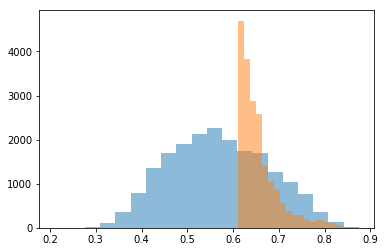

In [89]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(gcdist_pos, bins=20, alpha=0.5)
plt.hist(gcdist_neg, bins=20, alpha=0.5)
plt.show()

In [82]:
avgpos_gcref

array([[[0.21634415, 0.28420917, 0.2846407 , 0.21480585],
        [0.21634415, 0.28420917, 0.2846407 , 0.21480585],
        [0.21634415, 0.28420917, 0.2846407 , 0.21480585],
        ...,
        [0.21634415, 0.28420917, 0.2846407 , 0.21480585],
        [0.21634415, 0.28420917, 0.2846407 , 0.21480585],
        [0.21634415, 0.28420917, 0.2846407 , 0.21480585]]])

In [ ]:


def run_interpretation_methods(sequences, preact_model,
                               modeljson, modelweights):
    

In [62]:
#identify a subset of 5000 sequences on which to run imp scoring

toppredpos_indices = [x[0] for x in seqids_top_pred_positives]
subset_pos_onehot = pos_onehotseqs[toppredpos_indices]

#run the different interpretation methods on subset_pos_onehot



In [51]:
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 393, 320)          10560     
_________________________________________________________________
activation_1 (Activation)    (None, 393, 320)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 386, 320)          819520    
_________________________________________________________________
activation_2 (Activation)    (None, 386, 320)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 386, 320)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 96, 320)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 89, 480)           1229280   
__________

In [63]:
len(subset_pos_onehot)

5000

In [50]:
sum(pos_preds==1.0)

23526

In [15]:
!ls /users/eprakash/projects/benchmarking/notebooks/momma_dragonn/gm12878*

/users/eprakash/projects/benchmarking/notebooks/momma_dragonn/gm12878_model_architecture.json
/users/eprakash/projects/benchmarking/notebooks/momma_dragonn/gm12878_weights.h5


In [17]:
!zcat /users/eprakash/projects/benchmarking/newdata/GM12878/GM12878.summits.implanted.valid.bed.gz | head

dinuc_shuffled_motifs_implanted_chr10:34716976-34717376	ACAGACCCAGGAGGAATGATTATCCTTGAAATTGGCTCCTTCCTCAAAGTAATTCCCATGAATCTAGAAAACCTCTCTGAAAGAGCTTAGCTGCTAGATCACTTAGAAATGGACTCTATAAAGAGCCCCTCATCTTGCCCAAGTTCAAGTAATTTACTCTCGTGCCCAGTCAAAAGCAGGGAACCTAGCAGGAGCAACAAGTTGCTTTCAAGAACCCAAGGCTGCCTGGAATTATCCACCAAATGAAATGGCTAAGCAGTGTCCTTACTACTGGAAACCAATGACCAGTTACCTGCTTTTCCGCACAACAAGTCAAAGAGATAGTATTCCCCTCATCATCATCGTAAAACACTTATACATACAAGACTAAACAATCAAAATGTCAATAAAATGAAACCTC
dinuc_shuffled_motifs_implanted_chr10:32190897-32191297	AGATATATGTGACATTATTAAAGATAAACATGAAACTGGTCAAACCAGCTTTCATTATATGAACAGTAACAATCCCTCTAGAAGTCCAGAGTAGAAATGATTATTTATATTTCAAACTCAAATTCATTGGCTAGAACAAGAAATGAACCTGGAATTAGTGCCCAAAGATAATCACAGGTTAGGCAAAAATACAAAAAGTTTTAACTTGTGCCAAAACAAGGAAAATaacagaatTAGGGATAcagaaataGAAGCTTCCATACAACACAGGAGCCCTAAATCTTTTTAATTACACGAAGACCAAATGCTAAGGAGGGATTAAATGGATAGACCTATTCAAGCTACTTCCAGAAAATAATAAAGAAATCAGGGAAAGGGGTACCATAATTTAAGCTCACCT
dinuc_shuffled_motifs_implanted_chr10:30639954-30640354	CTGGTTCCCAGTTATCTTAAGTTATTAATT

In [18]:
!grep chr11:71978031-71978431 /users/eprakash/projects/benchmarking/newdata/GM12878/400bp/GM12878.motif.matches.txt

15-GTGACTRA-48070	chr11:71978031-71978431	14	21	-	5.331139	GTAGAAAC
8-TGAAACYRNN-33212	chr11:71978031-71978431	16	25	+	6.907642	AGAAACTGAA
8-CGAAACBGAACN-44096	chr11:71978031-71978431	16	27	+	6.229017	AGAAACTGAAAA
2-TTTCRSTTCC-27032	chr11:71978031-71978431	17	26	-	6.871742	GAAACTGAAA
4-BCGGTTTC-64319	chr11:71978031-71978431	17	24	-	6.629700	GAAACTGA
4-TGGTTTCASTTY-6406	chr11:71978031-71978431	18	29	-	9.549813	AAACTGAAAAAA
2-TTYCGSTT-28015	chr11:71978031-71978431	19	26	-	5.425699	AACTGAAA
8-TGAAACYRNN-33213	chr11:71978031-71978431	196	205	+	7.060089	AGAAACCAGG
4-BCGGTTTC-64320	chr11:71978031-71978431	197	204	-	6.691214	GAAACCAG
4-GGGRRTTTYC-57722	chr11:71978031-71978431	204	213	+	7.014103	GGTAACTTCC
11-GACGTNAC-20077	chr11:71978031-71978431	205	212	-	5.232004	GTAACTTC
1-CACTTCCTSTTY-34125	chr11:71978031-71978431	207	218	+	8.594434	AACTTCCCCTTT
1-RACCGGAAGT-34361	chr11:71978031-71978431	208	217	-	7.404138	ACTTCCCCTT
13-DRRGGSSRRR-21765	chr11:71978031-71978431	209	218	-	6.607031	CTTCCCCTT